In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm



training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

c:\Users\ben\miniconda3\envs\cse151b\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


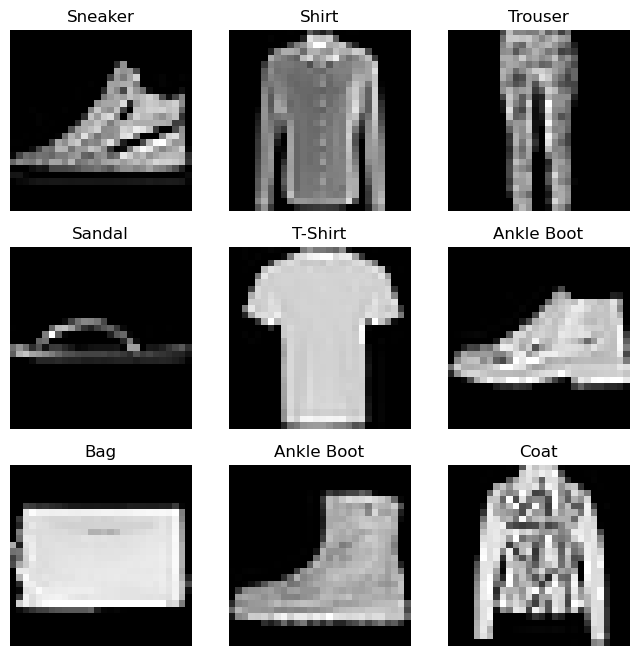

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        # encodes the image from 784 to 128 dimension latent space representation
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )   
        # decodes the image from 128 to 784 dimension
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        output = self.decoder(x)
        return output

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [4]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
train_loss_history = []
test_loss_history = []

## Training

In [6]:
epoches = 20

def test():
    sum_loss = 0
    # turn off gradients
    with torch.no_grad():
        model.eval()

        # iterate over test dataset
        for image, label in tqdm(test_dataloader):
            image = image.to(device) # move to device, e.g. GPU

            decoded_image = model(image)
            loss = loss_fn(decoded_image, image.reshape(-1, 28*28))
            
            # backpropagation, compute gradients
            sum_loss += loss / test_dataloader.batch_size

        average_loss = sum_loss / len(test_dataloader)
        return average_loss


def train(epoches):
    for epoch in range(epoches):
        print("=========================================")
        print(f"Epoch {epoch+1}:")
        model.train()
        sum_loss = 0

        for image, label in tqdm(train_dataloader):
            optimizer.zero_grad() # clear gradients for this training step
            image = image.to(device) # move to device, e.g. GPU

            decoded_image = model(image)
            loss = loss_fn(decoded_image, image.reshape(-1, 28*28))
            
            # backpropagation, compute gradients
            loss.backward()
            optimizer.step()
            sum_loss += loss / train_dataloader.batch_size

        average_epoch_loss = sum_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Epoch Loss: {average_epoch_loss:.10f}")
        train_loss_history.append(average_epoch_loss.to('cpu').detach().numpy())

        test_loss = test()
        print(f"Test Loss: {test_loss:.10f}")
        test_loss_history.append(test_loss.to('cpu').numpy())


train(epoches)


Epoch 1:


100%|██████████| 938/938 [00:09<00:00, 100.86it/s]


Epoch 1, Epoch Loss: 0.0005078635


100%|██████████| 157/157 [00:00<00:00, 213.32it/s]


Test Loss: 0.0003349455
Epoch 2:


100%|██████████| 938/938 [00:07<00:00, 123.51it/s]


Epoch 2, Epoch Loss: 0.0003094186


100%|██████████| 157/157 [00:00<00:00, 212.16it/s]


Test Loss: 0.0002909891
Epoch 3:


100%|██████████| 938/938 [00:07<00:00, 125.57it/s]


Epoch 3, Epoch Loss: 0.0002709427


100%|██████████| 157/157 [00:00<00:00, 209.61it/s]


Test Loss: 0.0002551519
Epoch 4:


100%|██████████| 938/938 [00:07<00:00, 127.43it/s]


Epoch 4, Epoch Loss: 0.0002420371


100%|██████████| 157/157 [00:00<00:00, 215.96it/s]


Test Loss: 0.0002326185
Epoch 5:


100%|██████████| 938/938 [00:07<00:00, 127.00it/s]


Epoch 5, Epoch Loss: 0.0002228581


100%|██████████| 157/157 [00:00<00:00, 214.48it/s]


Test Loss: 0.0002211730
Epoch 6:


100%|██████████| 938/938 [00:07<00:00, 124.43it/s]


Epoch 6, Epoch Loss: 0.0002100866


100%|██████████| 157/157 [00:00<00:00, 211.16it/s]


Test Loss: 0.0002072344
Epoch 7:


100%|██████████| 938/938 [00:07<00:00, 127.22it/s]


Epoch 7, Epoch Loss: 0.0002006798


100%|██████████| 157/157 [00:00<00:00, 211.59it/s]


Test Loss: 0.0001994730
Epoch 8:


100%|██████████| 938/938 [00:07<00:00, 125.10it/s]


Epoch 8, Epoch Loss: 0.0001927371


100%|██████████| 157/157 [00:00<00:00, 211.59it/s]


Test Loss: 0.0001909257
Epoch 9:


100%|██████████| 938/938 [00:07<00:00, 123.90it/s]


Epoch 9, Epoch Loss: 0.0001850741


100%|██████████| 157/157 [00:00<00:00, 209.89it/s]


Test Loss: 0.0001888983
Epoch 10:


100%|██████████| 938/938 [00:07<00:00, 129.50it/s]


Epoch 10, Epoch Loss: 0.0001802003


100%|██████████| 157/157 [00:00<00:00, 219.27it/s]


Test Loss: 0.0001826853
Epoch 11:


100%|██████████| 938/938 [00:07<00:00, 128.92it/s]


Epoch 11, Epoch Loss: 0.0001751505


100%|██████████| 157/157 [00:00<00:00, 208.50it/s]


Test Loss: 0.0001768810
Epoch 12:


100%|██████████| 938/938 [00:07<00:00, 126.33it/s]


Epoch 12, Epoch Loss: 0.0001709393


100%|██████████| 157/157 [00:00<00:00, 212.74it/s]


Test Loss: 0.0001758436
Epoch 13:


100%|██████████| 938/938 [00:07<00:00, 126.16it/s]


Epoch 13, Epoch Loss: 0.0001671691


100%|██████████| 157/157 [00:00<00:00, 207.12it/s]


Test Loss: 0.0001700432
Epoch 14:


100%|██████████| 938/938 [00:07<00:00, 125.99it/s]


Epoch 14, Epoch Loss: 0.0001638772


100%|██████████| 157/157 [00:00<00:00, 207.95it/s]


Test Loss: 0.0001669391
Epoch 15:


100%|██████████| 938/938 [00:07<00:00, 127.20it/s]


Epoch 15, Epoch Loss: 0.0001608892


100%|██████████| 157/157 [00:00<00:00, 210.44it/s]


Test Loss: 0.0001643778
Epoch 16:


100%|██████████| 938/938 [00:07<00:00, 126.64it/s]


Epoch 16, Epoch Loss: 0.0001579216


100%|██████████| 157/157 [00:00<00:00, 186.02it/s]


Test Loss: 0.0001631594
Epoch 17:


100%|██████████| 938/938 [00:07<00:00, 126.71it/s]


Epoch 17, Epoch Loss: 0.0001553697


100%|██████████| 157/157 [00:00<00:00, 212.16it/s]


Test Loss: 0.0001613979
Epoch 18:


100%|██████████| 938/938 [00:07<00:00, 127.88it/s]


Epoch 18, Epoch Loss: 0.0001532610


100%|██████████| 157/157 [00:00<00:00, 215.36it/s]


Test Loss: 0.0001597934
Epoch 19:


100%|██████████| 938/938 [00:07<00:00, 127.10it/s]


Epoch 19, Epoch Loss: 0.0001507665


100%|██████████| 157/157 [00:00<00:00, 208.50it/s]


Test Loss: 0.0001555452
Epoch 20:


100%|██████████| 938/938 [00:07<00:00, 127.21it/s]


Epoch 20, Epoch Loss: 0.0001486127


100%|██████████| 157/157 [00:00<00:00, 214.48it/s]

Test Loss: 0.0001547361


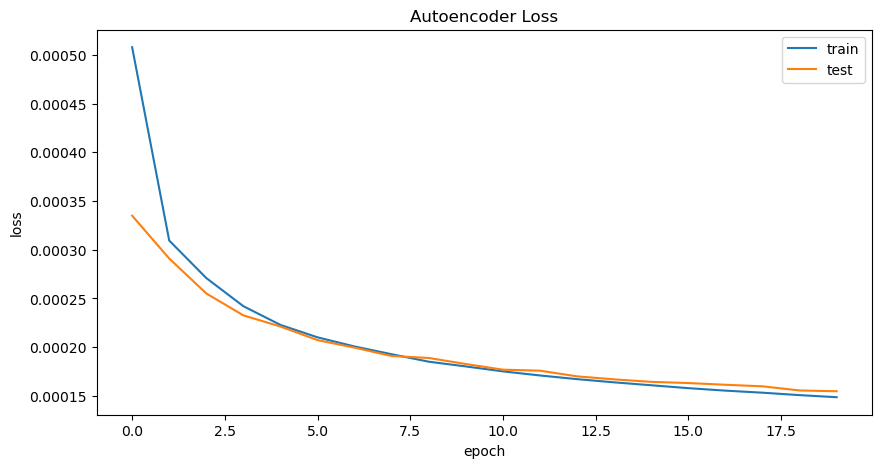

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Autoencoder Loss")
plt.plot(train_loss_history, label="train")
plt.plot(test_loss_history, label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

tensor(0.0093, device='cuda:0')


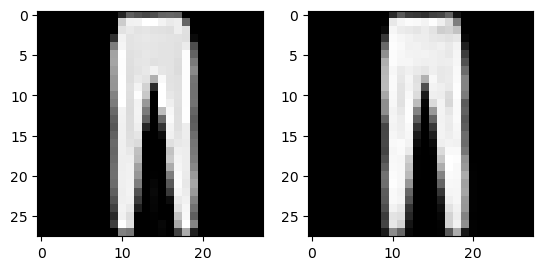

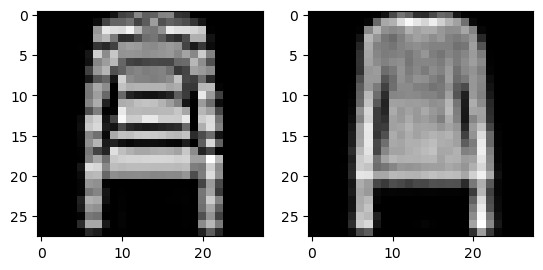

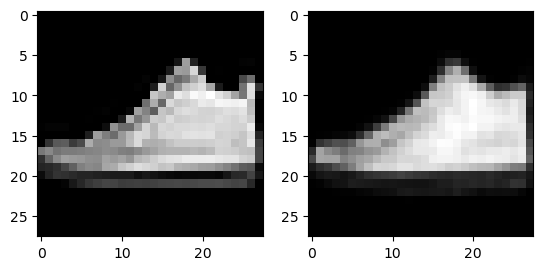

In [8]:
def sample_one_image():
    with torch.no_grad():
        model.eval()
        for image, label in test_dataloader:
            image = image.to(device)
            decoded_image = model(image)
            batch_loss = loss_fn(decoded_image, image.reshape(-1, 28*28))
            print(batch_loss)
            decoded_image = decoded_image.reshape(-1, 28, 28)
            decoded_image = decoded_image.cpu().numpy()
            for i, sample_img in enumerate(decoded_image[0:3]):
                plt.subplot(1, 2, 1)
                plt.imshow(image[i].cpu().numpy().reshape(28, 28), cmap="gray")
                plt.subplot(1, 2, 2)
                plt.imshow(sample_img, cmap="gray")
                plt.show()
            break
        
sample_one_image()
